In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pulses import RadarPulseGenerator, CommPulseGenerator

def generate_walsh_matrix(order):
    # Order of Walsh matrix must be a power of 2
    order = 2 ** int(np.ceil(np.log2(order)))
    
    # Initialize Walsh matrix with Hadamard matrix
    walsh_matrix = hadamard_matrix(order)
    
    # Convert -1s in Hadamard matrix to 0s for Walsh code representation
    walsh_matrix[walsh_matrix == +1] = 0
    walsh_matrix[walsh_matrix == -1] = 1
    
    return walsh_matrix

def hadamard_matrix(order):
    # Recursive method to generate Hadamard matrix of given order
    if order == 1:
        return np.array([[1]])
    else:
        h = hadamard_matrix(order // 2)
        return np.block([[h, h], [h, -h]])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
# print(device)
t = torch.linspace(0, 1e-4, int(100000), device=device)

mycdma_code = generate_walsh_matrix(8)

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)

B = 1e6
K = 5
T = 1e-4

# g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k+1 , :])
# g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k)
# g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)

L_list = [100, 120, 140, 160, 180, 200]
MMSE_wc_LFM = torch.zeros(len(L_list), device=device)
MMSE_wc_Barker = torch.zeros(len(L_list), device=device)
MMSE_wc_Gaussian = torch.zeros(len(L_list), device=device)
MMSE_woc_LFM = torch.zeros(len(L_list), device=device)
MMSE_woc_Barker = torch.zeros(len(L_list), device=device)
MMSE_woc_Gaussian = torch.zeros(len(L_list), device=device)
index = 0
myRadarPulses = RadarPulseGenerator(t, 1, T, device)
Normilize1 = torch.sum(torch.abs(myRadarPulses.LFM_pulse(B))**2)*(t[1]-t[0])
Normilize2 = torch.sum(torch.abs(myRadarPulses.Barker_pulse(b))**2)*(t[1]-t[0])
Normilize3 = torch.sum(torch.abs(myRadarPulses.Gaussian_pulse(B))**2)*(t[1]-t[0])
for L in L_list:
    Tb = T/L
    myCommPulses = CommPulseGenerator(t, Tb, T, device)

    # g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k+1 , :])
    g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k)
    # g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)

    # print(mycdma_code)

    g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
    for l in range(L):
        for k in range(K):
            g_vec[l*K + k, :] = g_funcs(l, k+1)
    Q = torch.matmul(g_vec, g_vec.conj().T)*(t[1]-t[0])

    R = myRadarPulses.LFM_pulse(B).repeat(K*L, 1)
    # print(myRadarPulses.LFM_pulse(B).shape)
    nom = torch.matmul(R[0,:][torch.newaxis, :], g_vec.conj().T)*(t[1]-t[0])
    nom2 = torch.abs(nom)**2
    denom_ = torch.sum(nom2.reshape((L,K)), dim=0).repeat((1,L))
    denum = np.sqrt(1/L)*torch.sqrt(denom_)
    c_opt_prime = nom/denum
    c_opt_prime = c_opt_prime[0, :]
    G = torch.diag(torch.matmul(R, g_vec.conj().T))*(t[1]-t[0])
    c_opt = torch.matmul(G, torch.inverse(Q))

    # print(torch.sum(torch.abs(c_opt_prime.reshape((L,K))**2), dim=0))
    # print(torch.sum(torch.abs(c_opt.reshape((L,K))**2), dim=0))

    s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
    print(G.shape)
    # MMSE_woc_LFM[index] = torch.sum(torch.abs(s_opt - myRadarPulses.LFM_pulse(B))**2)*(t[1]-t[0])
    MMSE_woc_LFM[index] = Normilize1 - G[torch.newaxis, :] @ torch.inverse(Q) @ G[torch.newaxis, :].conj().T
    # plt.figure()
    # plt.plot(t.cpu().numpy(), np.real(s_opt.cpu().numpy()), 'b', marker='', linestyle=':', linewidth=1.5, markersize=3)
    # plt.plot(t.cpu().numpy(), np.real(myRadarPulses.LFM_pulse(B).cpu().numpy()), 'r', linestyle='-', linewidth=1.5, markersize=3)
    # print(f"Wmin = {torch.sum(torch.abs(s_opt - myRadarPulses.LFM_pulse(B))**2)*(t[1]-t[0])}")
    
    s_opt = torch.sum(c_opt_prime[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
    MMSE_wc_LFM[index] = torch.sum(torch.abs(s_opt - myRadarPulses.LFM_pulse(B))**2)*(t[1]-t[0])
    # plt.figure()
    # plt.plot(t.cpu().numpy(), np.real(s_opt.cpu().numpy()), 'b', marker='', linestyle=':', linewidth=1.5, markersize=3)
    # plt.plot(t.cpu().numpy(), np.real(myRadarPulses.LFM_pulse(B).cpu().numpy()), 'r', linestyle='-', linewidth=1.5, markersize=3)
    # print(f"Wmin = {torch.sum(torch.abs(s_opt - myRadarPulses.LFM_pulse(B))**2)*(t[1]-t[0])}")

    #====================================================================================
    R = myRadarPulses.Barker_pulse(b).repeat(K*L, 1)
    nom = torch.matmul(R[0,:][torch.newaxis, :], g_vec.conj().T)*(t[1]-t[0])
    nom2 = torch.abs(nom)**2
    nom2 = nom2[0, :]
    denom_ = torch.sum(nom2.reshape((L,K)), dim=0).repeat((1,L))
    denum = np.sqrt(1/L)*torch.sqrt(denom_)
    c_opt_prime = nom/denum
    c_opt_prime = c_opt_prime[0, :]
    G = torch.diag(torch.matmul(R, g_vec.conj().T))*(t[1]-t[0])
    c_opt = torch.matmul(G, torch.inverse(Q))

    # print(torch.sum(torch.abs(c_opt_prime.reshape((L,K))**2), dim=0))
    # print(torch.sum(torch.abs(c_opt.reshape((L,K))**2), dim=0))

    s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
    # MMSE_woc_Barker[index] = torch.sum(torch.abs(s_opt - myRadarPulses.Barker_pulse(b))**2)*(t[1]-t[0])
    MMSE_woc_Barker[index] = Normilize2 - G[torch.newaxis, :] @ torch.inverse(Q) @ G[torch.newaxis, :].conj().T
    # plt.figure()
    # plt.plot(t.cpu().numpy(), np.real(s_opt.cpu().numpy()), 'b', marker='', linestyle=':', linewidth=1.5, markersize=3)
    # plt.plot(t.cpu().numpy(), np.real(myRadarPulses.Barker_pulse(b).cpu().numpy()), 'r', linestyle='-', linewidth=1.5, markersize=3)

    s_opt = torch.sum(c_opt_prime[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
    MMSE_wc_Barker[index] = torch.sum(torch.abs(s_opt - myRadarPulses.Barker_pulse(b))**2)*(t[1]-t[0])
    # plt.figure()
    # plt.plot(t.cpu().numpy(), np.real(s_opt.cpu().numpy()), 'b', marker='', linestyle=':', linewidth=1.5, markersize=3)
    # plt.plot(t.cpu().numpy(), np.real(myRadarPulses.Barker_pulse(b).cpu().numpy()), 'r', linestyle='-', linewidth=1.5, markersize=3)

    #====================================================================================
    R = myRadarPulses.Gaussian_pulse(B).repeat(K*L, 1)
    nom = torch.matmul(R[0,:][torch.newaxis, :], g_vec.conj().T)*(t[1]-t[0])
    nom2 = torch.abs(nom)**2
    nom2 = nom2[0, :]
    denom_ = torch.sum(nom2.reshape((L,K)), dim=0).repeat((1,L))
    denum = np.sqrt(1/L)*torch.sqrt(denom_)
    c_opt_prime = nom/denum
    c_opt_prime = c_opt_prime[0, :]
    G = torch.diag(torch.matmul(R, g_vec.conj().T))*(t[1]-t[0])
    c_opt = torch.matmul(G, torch.inverse(Q))

    # print(torch.sum(torch.abs(c_opt_prime.reshape((L,K))**2), dim=0))
    # print(torch.sum(torch.abs(c_opt.reshape((L,K))**2), dim=0))

    s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
    # MMSE_woc_Gaussian[index] = torch.sum(torch.abs(s_opt - myRadarPulses.Gaussian_pulse(B))**2)*(t[1]-t[0])
    MMSE_woc_Gaussian[index] = Normilize3 - G[torch.newaxis, :] @ torch.inverse(Q) @ G[torch.newaxis, :].conj().T
    # plt.figure()
    # plt.plot(t.cpu().numpy(), np.real(s_opt.cpu().numpy()), 'b', marker='', linestyle=':', linewidth=1.5, markersize=3)
    # plt.plot(t.cpu().numpy(), np.real(myRadarPulses.Gaussian_pulse(B).cpu().numpy()), 'r', linestyle='-', linewidth=1.5, markersize=3)

    s_opt = torch.sum(c_opt_prime[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
    MMSE_wc_Gaussian[index] = torch.sum(torch.abs(s_opt - myRadarPulses.Gaussian_pulse(B))**2)*(t[1]-t[0])
    # plt.figure()
    # plt.plot(t.cpu().numpy(), np.real(s_opt.cpu().numpy()), 'b', marker='', linestyle=':', linewidth=1.5, markersize=3)
    # plt.plot(t.cpu().numpy(), np.real(myRadarPulses.Gaussian_pulse(B).cpu().numpy()), 'r', linestyle='-', linewidth=1.5, markersize=3)
    index = index + 1
    print(index)

torch.Size([500])


C:\Users\Ali\AppData\Local\Temp\ipykernel_5784\2726253126.py:89: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:305.)
  MMSE_woc_LFM[index] = Normilize1 - G[torch.newaxis, :] @ torch.inverse(Q) @ G[torch.newaxis, :].conj().T


1
torch.Size([600])
2
torch.Size([700])
3
torch.Size([800])
4
torch.Size([900])
5
torch.Size([1000])
6


(100.0, 200.0)

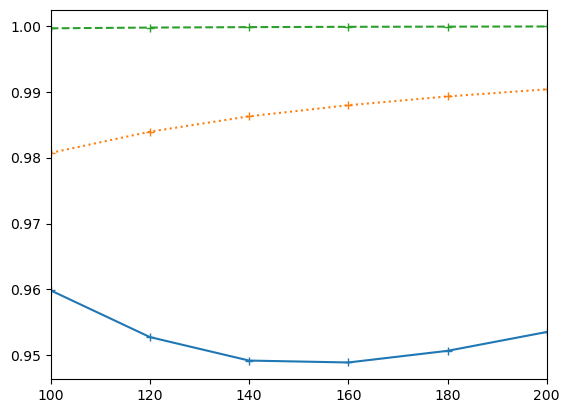

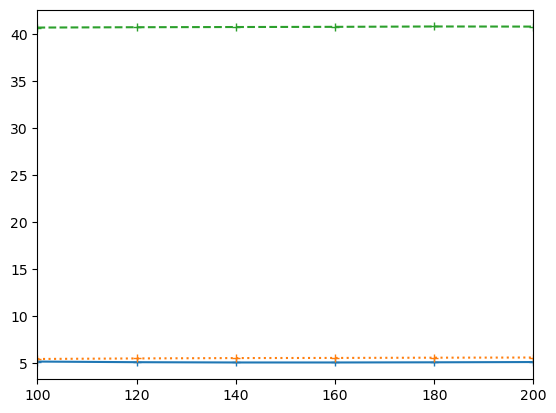

In [2]:
plt.figure()
plt.plot(np.array(L_list), MMSE_woc_LFM/Normilize1, marker='+', linestyle='-')
plt.plot(np.array(L_list), MMSE_woc_Barker/Normilize2, marker='+', linestyle=':')
plt.plot(np.array(L_list), MMSE_woc_Gaussian/Normilize3, marker='+', linestyle='--')
plt.xlim([100,200])

plt.figure()
plt.plot(np.array(L_list), MMSE_wc_LFM/Normilize1, marker='+', linestyle='-')
plt.plot(np.array(L_list), MMSE_wc_Barker/Normilize2, marker='+', linestyle=':')
plt.plot(np.array(L_list), MMSE_wc_Gaussian/Normilize3, marker='+', linestyle='--')
plt.xlim([100,200])

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pulses import RadarPulseGenerator, CommPulseGenerator
device = 'cuda'
B = 1e6
K = 5
T = 1e-4
t = torch.linspace(0, 1e-4, int(10000), device=device)
b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
L_list = [100, 120, 140, 160, 180, 200]
p1 = torch.zeros(len(L_list), device=device)
p2 = torch.zeros(len(L_list), device=device)
p3 = torch.zeros(len(L_list), device=device)
index = 0
for L in L_list:
    Tb = T/L
    myRadarPulses = RadarPulseGenerator(t, Tb, T, device)
    myCommPulses = CommPulseGenerator(t, Tb, T, device)

    R1 = myRadarPulses.LFM_pulse(B).repeat(K*L, 1)
    R2 = myRadarPulses.Barker_pulse(b).repeat(K*L, 1)
    R3 = myRadarPulses.Gaussian_pulse(B).repeat(K*L, 1)

    g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k)
    g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
    for l in range(L):
        for k in range(K):
            g_vec[l*K + k, :] = g_funcs(l, k+1)

    p1[index] = torch.sum(torch.abs((R1@g_vec.conj().T)*(t[1]-t[0]))**2)/Tb
    p2[index] = torch.sum(torch.abs((R2@g_vec.conj().T)*(t[1]-t[0]))**2)/Tb
    p3[index] = torch.sum(torch.abs((R3@g_vec.conj().T)*(t[1]-t[0]))**2)/Tb
    index += 1
    print(L)

Normilize1 = torch.sum(torch.abs(myRadarPulses.LFM_pulse(B))**2)*(t[1]-t[0])
Normilize2 = torch.sum(torch.abs(myRadarPulses.Barker_pulse(b))**2)*(t[1]-t[0])
Normilize3 = torch.sum(torch.abs(myRadarPulses.Gaussian_pulse(B))**2)*(t[1]-t[0])

plt.figure()
plt.plot(np.array(L_list), ((Normilize1-p1)/Normilize1).cpu(), marker='+', linestyle='-')
plt.plot(np.array(L_list), ((Normilize2-p2)/Normilize2).cpu(), marker='+', linestyle='-')
plt.plot(np.array(L_list), ((Normilize3-p3)/Normilize3).cpu(), marker='+', linestyle='-')

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from pulses import RadarPulseGenerator, CommPulseGenerator
device = 'cuda'
B = 1e6
K = 2
T = 1e-4
L = 2
t = torch.linspace(0, 1e-4, int(10000), device=device)
b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
L_list = [100, 120, 140, 160, 180, 200]
p1 = torch.zeros(len(L_list), device=device)
p2 = torch.zeros(len(L_list), device=device)
p3 = torch.zeros(len(L_list), device=device)
index = 0
Tb = T/L
myRadarPulses = RadarPulseGenerator(t, Tb, T, device)
myCommPulses = CommPulseGenerator(t, Tb, T, device)

R1 = myRadarPulses.LFM_pulse(B).repeat(K*L, 1)
R2 = myRadarPulses.Barker_pulse(b).repeat(K*L, 1)
R3 = myRadarPulses.Gaussian_pulse(B).repeat(K*L, 1)

# g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k+1 , :])
# g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k)
# g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)
A = g_vec@g_vec.conj().T*(t[1]-t[0])/Tb*K
print(Tb)
print(pd.DataFrame(A.cpu().numpy()))